In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import umap.umap_ as umap

from modules import processor

In [2]:
PATH = '/Users/kaledinaoa/data/data_sber_market_test_ml/'

train_raw_data = processor.load_csv("train", PATH)
sample_sumbission = processor.load_csv("sample_submission", PATH)

In [3]:
train_raw_data.head(20)
test_df = train_raw_data.copy()

In [4]:
test_df.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


In [5]:
# user_item_matrix

user_item_matrix = pd.pivot_table(test_df, 
                                  index='user_id', columns='cart', 
                                  values='order_completed_at',
                                  aggfunc='count', 
                                  fill_value=0
                                 )
 
user_item_matrix = user_item_matrix.astype(float) 
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)


cart,0,1,2,3,4,5,6,7,8,9,...,871,872,873,874,875,876,877,878,879,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
count_unique_carts = test_df.cart.unique().shape[0]
count_unique_users = test_df.user_id.unique().shape[0]

print("unique users = ",count_unique_users)
print("unique carts = ",count_unique_carts)

unique users =  20000
unique carts =  881


### model ALS

In [7]:
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight

In [8]:
itemid_to_id, userid_to_id, id_to_itemid, id_to_userid = processor.some_ids_preparation_to_als(user_item_matrix)

In [9]:
%%time 

def building_model(factors):
    model_als = AlternatingLeastSquares(factors=factors, # скрытые факторы
                                    regularization=0.001, # регуляризация, от переобучения модели
                                    iterations=30, 
                                    calculate_training_loss=True)
    
    model_als.fit(csr_matrix(user_item_matrix).tocsr(), show_progress=True)
    return model_als

model_als = building_model(10)

/Users/kaledinaoa/Desktop/SberMarketComp/als_env/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 21.8 s, sys: 739 ms, total: 22.5 s
Wall time: 7.23 s


In [10]:
model = model_als

# MODEL INFORMATION
print('item_factors:', model.item_factors.shape)
print('user_factors:', model.user_factors.shape)

# эмбеддинги items
item_factors=pd.DataFrame(model.item_factors)

# эмбеддинги users
user_factors=pd.DataFrame(model.user_factors)
# user_factors.head(3)

item_factors: (881, 10)
user_factors: (20000, 10)


In [11]:
reducer = umap.UMAP(n_components=2) # to 2-dimension
umap_embeddings_users = reducer.fit_transform(user_factors)
umap_embeddings_items = reducer.fit_transform(item_factors)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


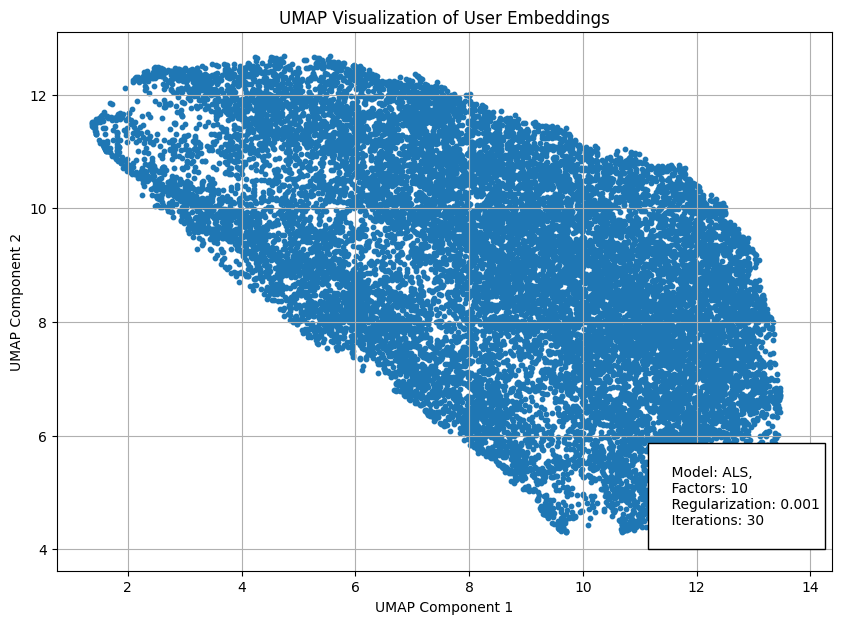

In [12]:
processor.figure_umap_embeddings(model, umap_embeddings_users, 'UMAP Visualization of User Embeddings')

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from modules import processor

### test user

In [21]:

TEST_USER_ID = 2

def reccomendation(model, n,  userid, user_item_matrix, userid_to_id):
    recs = model.recommend(userid=userid_to_id[userid],  
                        user_items=csr_matrix(user_item_matrix.loc[userid_to_id[TEST_USER_ID]]).tocsr(),  
                        N=n, 
                        recalculate_user=True,
                        filter_already_liked_items=False)
    return recs[0]

recs = reccomendation(model_als, 10, TEST_USER_ID, user_item_matrix, userid_to_id)
recs

array([ 57,  61,  14, 398,  23,  55,  22,  84, 169, 383], dtype=int32)

In [26]:
user_df = test_df[test_df["user_id"]==TEST_USER_ID]

In [32]:
def calculate_counttable_by_columnname(df, column_name):
        """
        Calculate a count table for a column.
        
        Args:
            df (DataFrame): The DataFrame to calculate the count table for.
            column_name (str): The name of the column to calculate the count table for.
            
        Returns:
            DataFrame: The count table.
        """
        counts = df[column_name].value_counts().reset_index()
        counts.columns = [column_name, 'count']
        counts = counts.sort_values(by='count')
        return counts

calculate_counttable_by_columnname(user_df, 'cart').sort_values(by="count",ascending=False).head(5)

,cart,count
0,23,11
1,57,10
2,61,8
3,82,7
4,403,7


In [29]:
# user_df

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
...,...,...,...
1976443,2,2020-06-18 18:31:08,382
1976444,2,2020-06-18 18:31:08,23
1976445,2,2020-06-18 18:31:08,100
1976446,2,2020-06-18 18:31:08,160


### reccomend

In [53]:
k = 30
score_more = 0.99
test_users = test_df.user_id.unique()
test_carts = test_df.cart.unique()
# k = test_carts.shape[0]


In [49]:
def calculate_recommendations_for_user(userid, model, k, user_item_matrix=user_item_matrix, userid_to_id=userid_to_id):

    def reccomendation(model, n,  userid, user_item_matrix, userid_to_id):
        ids, scores = model.recommend(userid=userid_to_id[userid],  
                            user_items=csr_matrix(user_item_matrix.loc[userid_to_id[userid]]).tocsr(),  
                            N=n, 
                            recalculate_user=True,
                            filter_already_liked_items=False)
        return ids, scores
    
    return reccomendation(model, k, userid, user_item_matrix, userid_to_id)


In [57]:
userid = 1

ids, scores = calculate_recommendations_for_user(userid, model, k)

test_results = pd.DataFrame(columns=['user_id','cart_id','target'])

# for userid in [userid]:

#     ids, scores = calculate_recommendations_for_user(userid, model, k)

#     for i in range(k):
#     test_results=pd.concat([pd.DataFrame([
#             {   
#                 'user_id': userid, 
#                 'cart_id': cart_id, 
#                 'target': target
#             }]),
#             test_results],ignore_index=True)

In [58]:
ids

array([ 55, 169, 798, 425, 170,  54, 804,  57,  61, 198, 179,  14, 808,
       171,  89, 398,  23, 157,  88,  84, 420,  22, 812, 383,  41, 799,
       173,  82,  42, 203], dtype=int32)

In [59]:
scores

array([0.81253123, 0.6347981 , 0.5816303 , 0.5671469 , 0.5668406 ,
       0.5505192 , 0.54435825, 0.5250367 , 0.5069757 , 0.50434864,
       0.49842182, 0.49235168, 0.48752657, 0.48202157, 0.47519213,
       0.47160232, 0.4702609 , 0.4559904 , 0.45049715, 0.44038564,
       0.42789274, 0.4110417 , 0.4073222 , 0.3962188 , 0.39044544,
       0.38313186, 0.38062337, 0.3750572 , 0.36062166, 0.35556135],
      dtype=float32)

In [ ]:
# df_for_metrics.sort_index().to_csv('df.csv', encoding='utf-8')